In [1]:
#basic package
import tqdm
import os
import numpy as np
import glob
import pandas as pd
import sys
import time
import datetime as dt
import itertools
import re
import math
from collections import Counter
import operator
from scipy import stats
from scipy.spatial.distance import cdist #for euclidean distance of consistency t
from numpy import inf
import networkx as nx
from dtaidistance import dtw
import random
from sklearn.preprocessing import normalize

#clustering
from sklearn.cluster import AgglomerativeClustering 

#scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#interpolate curves for clustering among birds with not exact same days tracked
#from scipy.interpolate import interp1d

#PCA
from sklearn import decomposition

#clustering
from sklearn.cluster import KMeans #only numerical var
from sklearn.metrics import silhouette_samples, silhouette_score
import kmodes
from kmodes.kmodes import KModes #with categorical var as well

#plot
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

In [9]:
PACKAGE_PARENT = '../'
SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser('__file__'))))
sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))
from UTILS import kmeans_clustering, sampen, chi2_distance, ts_visual, correct_key
import config_origins as config

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Define parameters

In [11]:
print('change the configuration file if not done yet!')
path_extracted_data = config.path_extracted_data
path_initial_data = config.path_initial_data
id_run = config.id_run
dico_matching = config.dico_matching
li_binmn = config.li_binmn
pal_class_treat = config.pal_class_treat
pal_treat = config.pal_treat
pal_class = config.pal_class
birth_date = config.birth_date
dico_night_hour = config.dico_night_hour
pal_interintre_treatment = config.pal_interintre_treatment
max_date_adaptability = config.max_date_adaptability
dico_pen_tr = config.dico_pen_tr
path_extracted_data_visual = os.path.join(path_extracted_data,'visual')
path_extracted_data_visual_corr = os.path.join(path_extracted_data,'visual','correlation')
path_extracted_data_visual_adap = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability')
path_extracted_data_visual_adap_clustering = os.path.join(path_extracted_data_visual_adap,'clustering')
path_extracted_data_visual_adap_clustering_chi2 = os.path.join(path_extracted_data_visual_adap_clustering,'chi2') 
path_extracted_data_visual_adap_clustering_dtw = os.path.join(path_extracted_data_visual_adap_clustering,'dtw') 
path_extracted_data_visual_adap_clustering_chi2_eucldist = os.path.join(path_extracted_data_visual_adap_clustering_chi2, 'eucldist')
#create a director if not existing
if not os.path.exists(path_extracted_data_visual_adap_clustering_chi2_eucldist):
    os.makedirs(path_extracted_data_visual_adap_clustering_chi2_eucldist)
if not os.path.exists(path_extracted_data_visual_adap_clustering_dtw):
    os.makedirs(path_extracted_data_visual_adap_clustering_dtw)
for nbr_bin in li_binmn:
    path_extracted_data_visual_adap_binmn = os.path.join(path_extracted_data,'visual','Treatment&Classs','adaptability',str(nbr_bin))
    #create a director if not existing
    if not os.path.exists(path_extracted_data_visual_adap_binmn):
        os.makedirs(path_extracted_data_visual_adap_binmn)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


change the configuration file if not done yet!


# Download variables

In [6]:
#distance measure (chi2, dtw)
df_intra = pd.read_csv(os.path.join(path_extracted_data_visual_adap ,id_run+'_df_interintra.csv'), sep=';', 
                      parse_dates=['level','level+1'], dayfirst=True)
#weeks of age starting on the first day where the bird was here during 24h
df_intra['weeks_in_laying_barn'] = df_intra['DOA'].map(lambda x: int((x-119)/7)+1)
display(df_intra[['level','DOA','weeks_in_laying_barn']].drop_duplicates().reset_index().head(3))
#remove weeks_in_laying_barn to avoid confusions
df_intra.drop(['WOA'],inplace=True,axis=1)
li_selected_hens = list(df_intra['henID1'].unique())
df_intra = df_intra[df_intra['type'].isin(['Intra individuals - OFH','Intra individuals - TRAN'])]
li_dtw = ['DTW_15_1_Zone','DTW_15_2_Zone','DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone']
df_intra['DTW_15_ALL'] = df_intra.apply(lambda x: sum(x[i] for i in li_dtw), axis=1)
print(df_intra.shape)
df_intra.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,index,level,DOA,weeks_in_laying_barn
0,0,2020-09-30,119,1
1,2183,2020-10-01,120,1
2,4400,2020-10-02,121,1


(6002, 92)


,level,level+1,henID1,henID2,PenID,Treatment,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,...,DTW_30_1_Zone,nbr_obs_l1_30_1_Zone,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS,weeks_in_laying_barn,DTW_15_ALL
0,2020-09-30,2020-10-01,hen_102,hen_102,3,OFH,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.128991,119,...,0.0,48,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,210.3
11,2020-09-30,2020-10-01,hen_6,hen_6,11,OFH,"[0.0, 0.2429513888888889, 0.05125, 0.008298611...","[0.0, 0.08805555555555555, 0.01, 0.03398148148...",0.067214,119,...,0.0,48,48,True,Intra individuals - OFH,LEXP,LEXP,LEXP,1,54.6
33,2020-09-30,2020-10-01,hen_84,hen_84,11,OFH,"[0.0, 0.8624652777777778, 0.1375347222222222, ...","[0.0, 0.7683950617283951, 0.15268518518518517,...",0.042568,119,...,0.0,48,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,67.0


In [12]:
#daily variables of the movements (one row per available hen per day)
df_daily = pd.read_csv(os.path.join(path_extracted_data, 'daily_ALL_Variable_Tranformed.csv'), sep=';',
                     parse_dates=['level'], dayfirst=True) 
df_daily['DOA'] = df_daily['level'].map(lambda x: (x-birth_date).days) 
df_daily['WOA'] = df_daily['DOA'].map(lambda x: math.ceil(x/7))
#first two month seems good from the %of hens not moving plot! and sounds good too (twice longer thatn they need to start moving)
print(df_daily.shape)
df_daily = df_daily[(df_daily['level']>dt.datetime(2020,9,29))&(df_daily['level']<=max_date_adaptability)] 
#df_daily.groupby(['PenID'])['Treatment'].agg(lambda x: set(x)).reset_index()
print(df_daily.shape)
display(df_daily[['level','DOA','WOA']].tail(3))
print(df_daily.shape)

#remove days that are not fully recorded
df_daily['nbr_sec_per_day'] = df_daily['level'].map(lambda x: dico_night_hour[correct_key(x,dico_night_hour)]['nbr_hour']*60*60)
df_daily['is_correct_amount_time'] = df_daily.apply(lambda x: x['nbr_sec_per_day']==x['verification_daily_total_duration'], axis=1)
df_daily[(~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull())][['level', 'HenID', 'Total_number_transition', 'dur_values', 'verification_daily_total_duration','nbr_sec_per_day']]
print(df_daily.shape)
display(df_daily = df_daily[~((~df_daily['is_correct_amount_time'])&(~df_daily['Total_number_transition'].isnull()))])
print(df_daily.shape)

#remove the days where the night had movement recorded but not the days
print(df_daily.shape)
df_daily = df_daily[['HenID','PenID','level','Treatment', 'CLASS', 'DOA','WOA','dur_values','dur_values_normalized','perc_duration_1_Zone', 'perc_duration_2_Zone',
          'perc_duration_3_Zone', 'perc_duration_4_Zone', 'perc_duration_5_Zone','Total_number_transition']]
#display(df_daily[df_daily.isna().any(axis=1)])
df_daily = df_daily[~df_daily.isna().any(axis=1)]
print(df_daily.shape)
df_daily.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(27214, 198)
(8679, 198)


,level,DOA,WOA
27117,2020-11-20,170,25
27118,2020-11-21,171,25
27119,2020-11-22,172,25


(8679, 198)
(8679, 198)
(8679, 198)
(8679, 198)
(7619, 15)


,HenID,PenID,level,Treatment,CLASS,DOA,WOA,dur_values,dur_values_normalized,perc_duration_1_Zone,perc_duration_2_Zone,perc_duration_3_Zone,perc_duration_4_Zone,perc_duration_5_Zone,Total_number_transition
0,hen_1,9,2020-09-30,OFH,EPI,119,17,"[0.0, 18886.0, 3488.0, 518.0, 5908.0]","[0.0, 0.6557638888888889, 0.12111111111111111,...",0.0,65.576389,12.111111,1.798611,20.513889,6.0
1,hen_1,9,2020-10-01,OFH,EPI,120,18,"[0.0, 9310.0, 5636.0, 0.0, 17454.0]","[0.0, 0.2873456790123457, 0.17395061728395061,...",0.0,28.734568,17.395062,0.000000,53.870370,12.0
2,hen_1,9,2020-10-02,OFH,EPI,121,18,"[0.0, 0.0, 551.0, 0.0, 31849.0]","[0.0, 0.0, 0.017006172839506173, 0.0, 0.982993...",0.0,0.000000,1.700617,0.000000,98.299383,2.0


In [13]:
mi = min(df_intra['weeks_in_laying_barn'].tolist())
ma = max(df_intra['weeks_in_laying_barn'].tolist())
print(mi, ma)

1 8


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Clustering on Chi2 & DTW

In [15]:
li_dist = ['DTW_15_1_Zone','DTW_15_2_Zone','DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','chi2distance']
li_dist = ['DTW_15_ALL','chi2distance']
li_weeks = [1,3,4,5,6]
df_dist_wib = df_intra[df_intra['weeks_in_laying_barn'].isin(li_weeks)][['weeks_in_laying_barn','henID1','PenID','Treatment',
                                                                        'CLASS']+li_dist].copy()
df_dist_wib = df_dist_wib.sort_values('weeks_in_laying_barn')
df_dist_wib = df_dist_wib.groupby(['weeks_in_laying_barn','henID1','PenID','Treatment','CLASS'])[li_dist].agg(lambda x: np.mean(x)).reset_index()
df_dist_wib.rename({'henID1':'HenID'}, axis=1, inplace=True)
df_dist_wib.to_csv(os.path.join(path_extracted_data_visual_adap_clustering, id_run+'df_dist_wib.csv'), sep=';', index=False)
print(df_dist_wib.shape)
df_dist_wib.head(3)

(665, 7)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,weeks_in_laying_barn,HenID,PenID,Treatment,CLASS,DTW_15_ALL,chi2distance
0,1,hen_1,9,OFH,EPIEPI,235.60,0.196786
1,1,hen_10,11,OFH,LEXP,266.02,0.297217
2,1,hen_101,5,OFH,MEXP,157.80,0.026668


In [16]:
li_2keep = ['HenID','PenID','Treatment','CLASS']
df_clustering_dist = df_dist_wib.pivot(index=li_2keep, columns='weeks_in_laying_barn', values=li_dist).reset_index()
print(df_clustering_dist.shape)
df_clustering_dist.head(3)

(133, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


HenID PenID Treatment   CLASS DTW_15_ALL              \
weeks_in_laying_barn                                           1           3   
0                       hen_1     9       OFH  EPIEPI     235.60   38.257143   
1                      hen_10    11       OFH    LEXP     266.02  180.228571   
2                     hen_101     5       OFH    MEXP     157.80  113.957143   

                                                         chi2distance  \
weeks_in_laying_barn           4           5           6            1   
0                       0.000000  111.071429  136.128571     0.196786   
1                     215.000000  272.900000  100.957143     0.297217   
2                     290.214286  213.900000  212.200000     0.026668   

                                                              
weeks_in_laying_barn         3         4         5         6  
0                     0.000000  0.000000  0.050605  0.058188  
1                     0.157713  0.087210  0.190007  0.061583  
2                     0.051550  0.069367  0.037834  0.002202

In [21]:
df_ = df_clustering_dist[li_dist+li_2keep].dropna(how='any').copy()
print(df_.shape)

#scaling data
df_kmeans = df_.copy()
sc = StandardScaler()
df_kmeans[li_dist] = sc.fit_transform(df_kmeans[li_dist])
display(df_kmeans[li_dist].head(3))

print(df_daily.shape, df_kmeans.shape)
li_ = range(2,8)
r, center_ = kmeans_clustering(df=df_kmeans, range_n_clusters=li_, drop_col_list=li_2keep)
if len(r)!=df_kmeans.shape[0]:
    print('ERROR')
    sys.exit()
df_['clustering_ID'] = r
display(df_[li_2keep+li_dist+['clustering_ID']].head(3))
print(df_daily.shape)
df_intra['HenID'] = df_intra['henID1'].copy()
df_.columns = [' '.join([str(i) for i in col]).strip() for col in df_.columns.values] # reset columns
dico_h_cl = dict(zip(df_['HenID'].tolist(), df_['clustering_ID'].tolist()))
df_intra_clusteringall = pd.merge(df_intra, df_[li_2keep+['clustering_ID']], on=li_2keep, how='outer')
print(df_intra_clusteringall.shape, df_intra.shape)
df_intra_clusteringall.head(3)

(133, 14)


C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


DTW_15_ALL                                          \
weeks_in_laying_barn          1         3         4         5         6   
0                      1.222234 -1.710963 -3.214518 -1.050895 -0.499853   
1                      1.707844  0.431577  0.756360  2.267577 -1.179436   
2                     -0.019727 -0.568548  2.145508  1.057717  0.970001   

                     chi2distance                                          
weeks_in_laying_barn            1         3         4         5         6  
0                        0.809465 -0.996725 -1.492533  0.166757  0.832409  
1                        1.841596  1.322204  0.555251  3.946800  0.956691  
2                       -0.938862 -0.238763  0.136288 -0.179554 -1.217266

C:\Users\camil\anaconda3\lib\site-packages\pandas\core\generic.py:3884: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(7619, 15) (133, 14)
For n_clusters = 2 The average silhouette_score is : 0.15088476756466881
For n_clusters = 3 The average silhouette_score is : 0.15589692796595944
For n_clusters = 4 The average silhouette_score is : 0.14716033522734215
For n_clusters = 5 The average silhouette_score is : 0.13546545034719373
For n_clusters = 6 The average silhouette_score is : 0.13556861679469406
For n_clusters = 7 The average silhouette_score is : 0.14760243515398877
Please let me know the numbers of clusters you want to search for 2
(133, 10)


HenID PenID Treatment   CLASS DTW_15_ALL              \
weeks_in_laying_barn                                           1           3   
0                       hen_1     9       OFH  EPIEPI     235.60   38.257143   
1                      hen_10    11       OFH    LEXP     266.02  180.228571   
2                     hen_101     5       OFH    MEXP     157.80  113.957143   

                                                         chi2distance  \
weeks_in_laying_barn           4           5           6            1   
0                       0.000000  111.071429  136.128571     0.196786   
1                     215.000000  272.900000  100.957143     0.297217   
2                     290.214286  213.900000  212.200000     0.026668   

                                                             clustering_ID  
weeks_in_laying_barn         3         4         5         6                
0                     0.000000  0.000000  0.050605  0.058188             0  
1                     0.157713  0.087210  0.190007  0.061583             1  
2                     0.051550  0.069367  0.037834  0.002202             1

(7619, 15)
(6002, 94) (6002, 93)


,level,level+1,henID1,henID2,PenID,Treatment,dur_values_normalized_henID1,dur_values_normalized_henID2,chi2distance,DOA,...,nbr_obs_l2_30_1_Zone,is_same_ind,type,HenID1_CLASS,HenID2_CLASS,CLASS,weeks_in_laying_barn,DTW_15_ALL,HenID,clustering_ID
0,2020-09-30,2020-10-01,hen_102,hen_102,3,OFH,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.128991,119,...,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,210.3,hen_102,0
1,2020-10-01,2020-10-02,hen_102,hen_102,3,OFH,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.000000,120,...,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,0.0,hen_102,0
2,2020-10-02,2020-10-03,hen_102,hen_102,3,OFH,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.000000,121,...,48,True,Intra individuals - OFH,MEXP,MEXP,MEXP,1,0.0,hen_102,0


In [22]:
df_['clustering_ID'].value_counts()

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0    69
1    64
Name: clustering_ID, dtype: int64

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


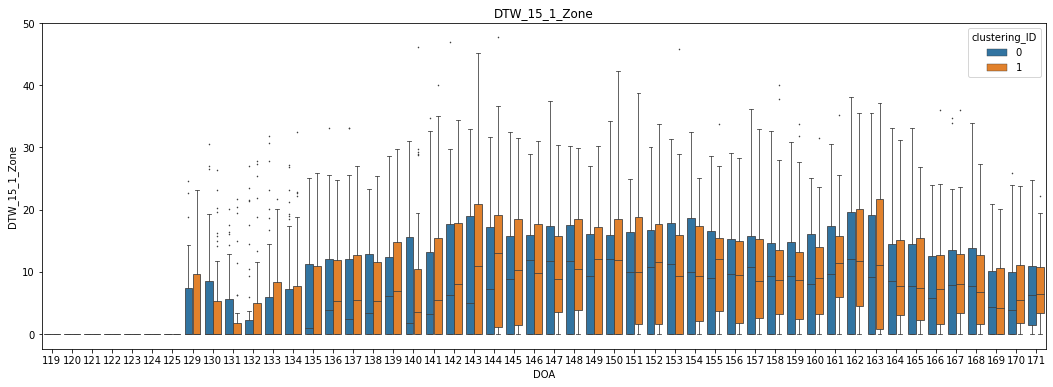

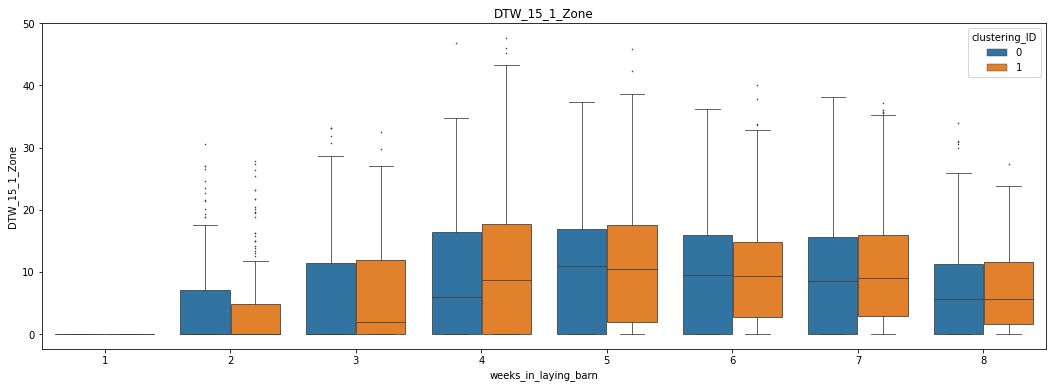

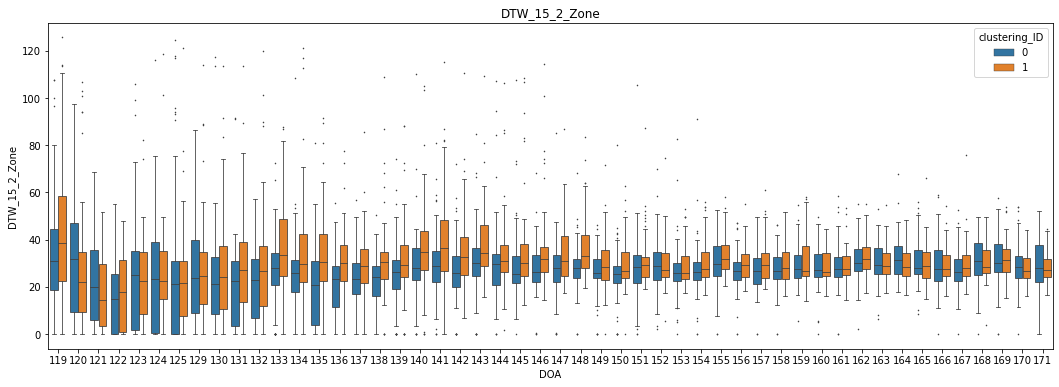

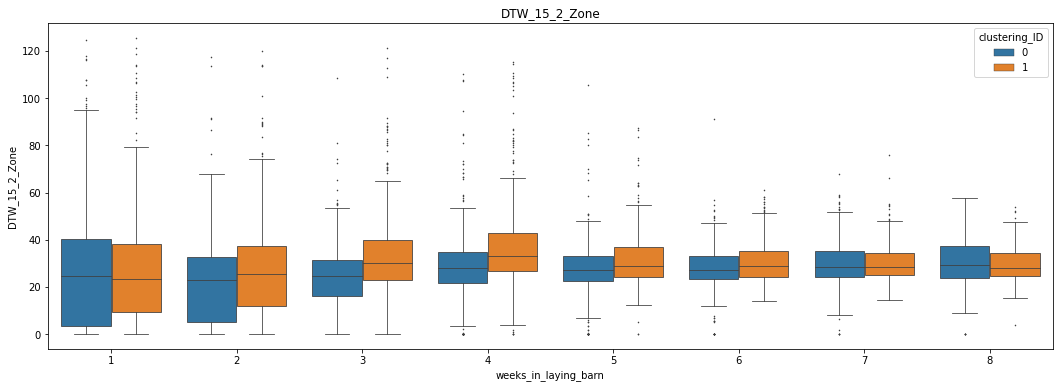

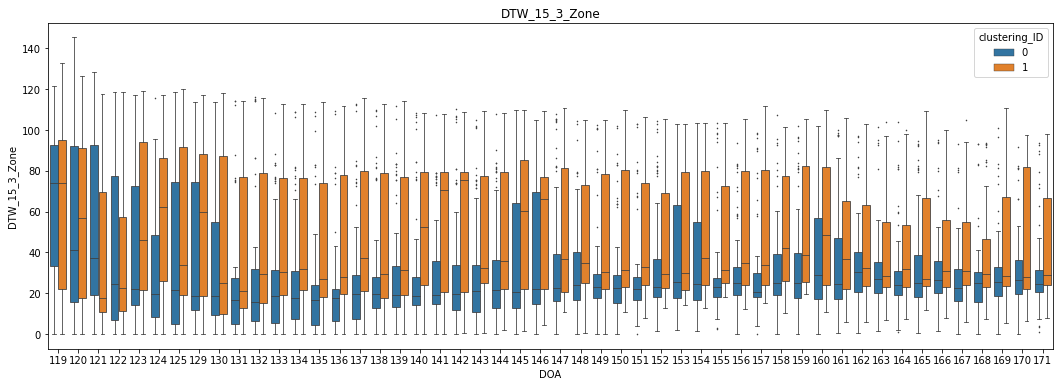

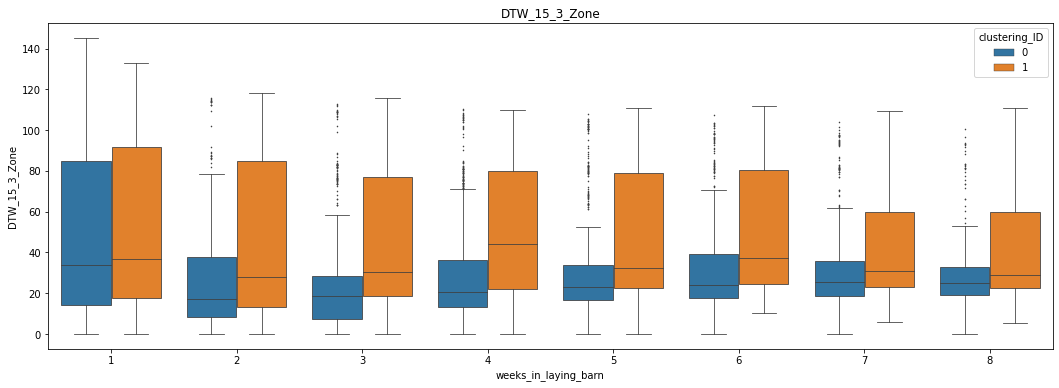

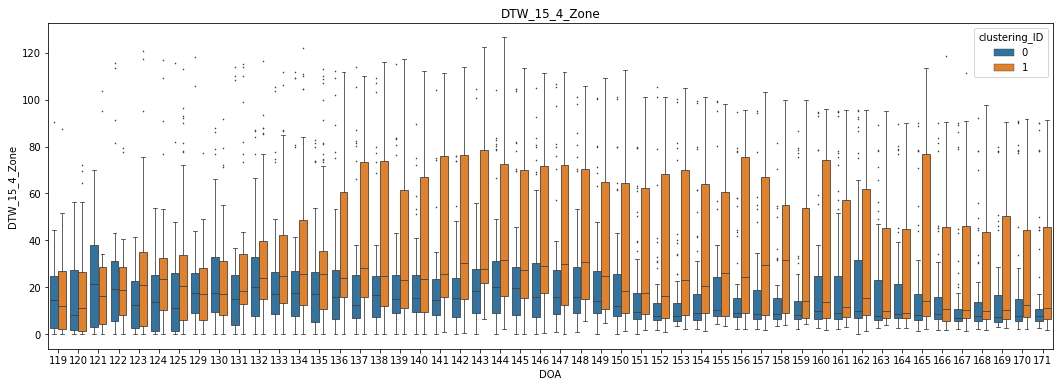

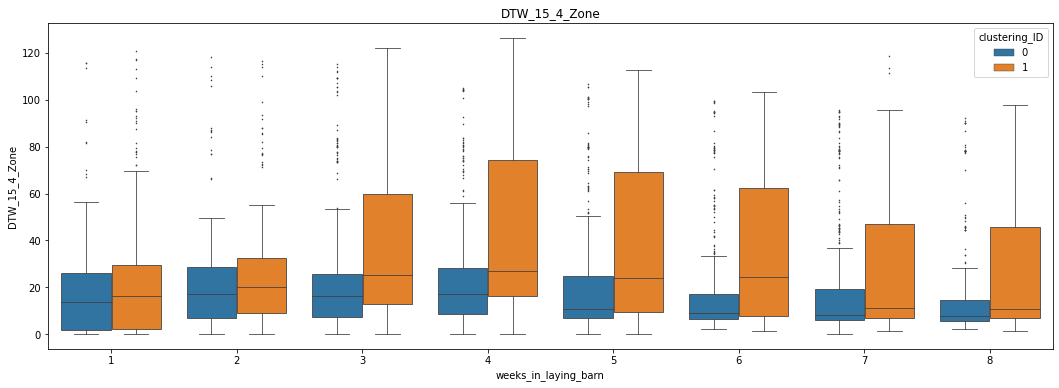

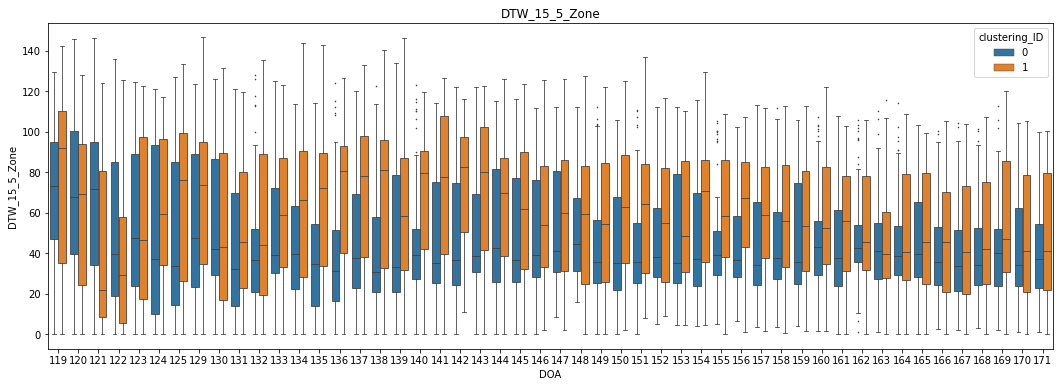

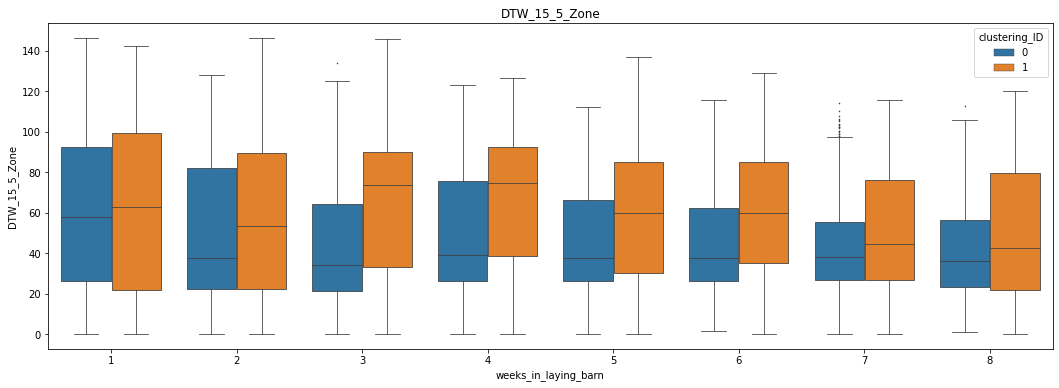

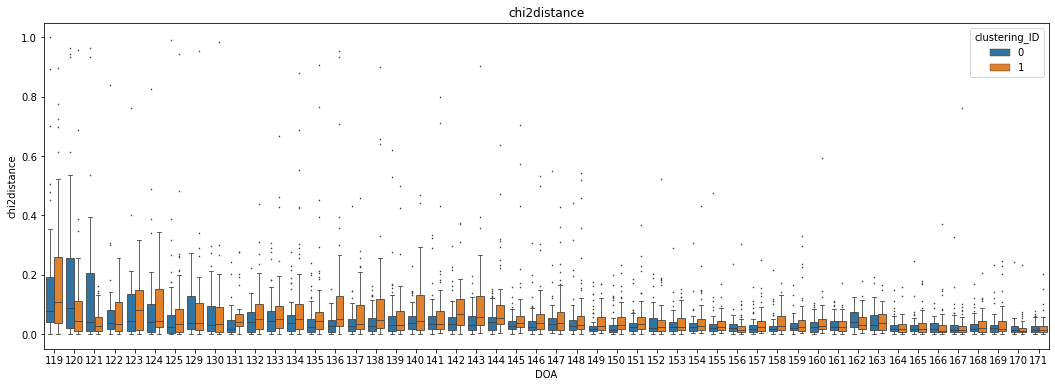

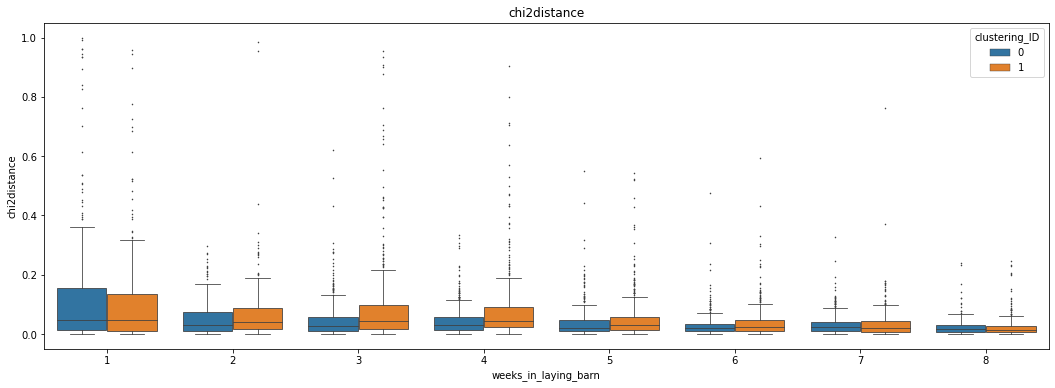

In [26]:
for v in ['DTW_15_1_Zone','DTW_15_2_Zone','DTW_15_3_Zone','DTW_15_4_Zone','DTW_15_5_Zone','chi2distance']:
    for t in ['DOA','weeks_in_laying_barn']:
        fig = plt.subplots(figsize=(18,6))
        sns.boxplot(data=df_intra_clusteringall, x=t,y=v, hue='clustering_ID', linewidth=0.8, fliersize=0.7)
        plt.title(v);
        plt.savefig(os.path.join(path_extracted_data_visual_adap_clustering, v+'_'+t+'.png'), bbox_inches='tight')
        plt.show()

In [25]:
#### one table with mean for each variable within each clusters
li_df = []
li_v = ['DTW_15_1_Zone 1', 'DTW_15_1_Zone 3', 'DTW_15_1_Zone 4',
       'DTW_15_2_Zone 1', 'DTW_15_2_Zone 3', 'DTW_15_2_Zone 4',
       'DTW_15_3_Zone 1', 'DTW_15_3_Zone 3', 'DTW_15_3_Zone 4',
       'DTW_15_4_Zone 1', 'DTW_15_4_Zone 3', 'DTW_15_4_Zone 4',
       'DTW_15_5_Zone 1', 'DTW_15_5_Zone 3', 'DTW_15_5_Zone 4',
       'chi2distance 1', 'chi2distance 3', 'chi2distance 4']
for k in df_['clustering_ID'].unique():
    df0 = df_[df_['clustering_ID']==k][li_v]
    li_df.append(df0.mean())
df_m = pd.concat(li_df,axis=1)
df_m.to_csv(os.path.join(path_extracted_data_visual_adap_clustering, 'clusters_properties.csv'))
print(df_m.shape)
df_m

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


KeyError: "['DTW_15_2_Zone 3', 'DTW_15_4_Zone 3', 'DTW_15_5_Zone 3', 'DTW_15_3_Zone 4', 'DTW_15_2_Zone 1', 'DTW_15_3_Zone 1', 'DTW_15_1_Zone 4', 'DTW_15_5_Zone 1', 'DTW_15_1_Zone 3', 'DTW_15_1_Zone 1', 'DTW_15_3_Zone 3', 'DTW_15_2_Zone 4', 'DTW_15_5_Zone 4', 'DTW_15_4_Zone 4', 'DTW_15_4_Zone 1'] not in index"

## Basics time series visual per cluster

In [319]:
#for being more reproductible, we open the file that was saved from cleaning
df = pd.read_csv(os.path.join(path_extracted_data, id_run+'_CLEANEDDATA.csv'), sep=';', parse_dates=['Timestamp','date'],
                 dayfirst=True) 
print(df.shape)
df.head(3)

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(1186950, 16)


,HenID,PenID,system,Zone,model_prediction,Timestamp,date,next_record_date,duration,previous_record_date,previous_duration,next_zone,previous_zone,previous_previous_zone,correction_is_consecutive_equal_initial_zone,is_WG_open
0,hen_111,pen11,10 - 12,3_Zone,1.0,2020-09-30 00:01:25,2020-09-30,2020-09-30 00:01:38.000,0 days 00:00:13,NaN,NaN,2_Zone,NaN,NaN,False,False
1,hen_111,pen11,10 - 12,2_Zone,1.0,2020-09-30 00:01:38,2020-09-30,2020-09-30 00:14:38.000,0 days 00:13:00,2020-09-30 00:01:25.000,0 days 00:00:13,2_Zone,3_Zone,NaN,False,False
2,hen_147,pen8,8 - 9,5_Zone,1.0,2020-09-30 00:30:49,2020-09-30,2020-09-30 00:33:26.000,0 days 00:02:37,NaN,NaN,5_Zone,NaN,NaN,False,False


In [ ]:
#small verification with the initial raw data, this cleaned data and the visual
#df[df['HenID']=='hen_1'].head(30)

In [ ]:
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,10,29)
#define the cluster dic
ts_visual(df, dmin, dmax, dico_hen_cluster=dico_h_clchi2, path_=path_extracted_data_visual_adap_clustering_visual, 
          name='chi2_only_')

In [337]:
#choose specific dates to plot, November is better as hens starts to move more and the algo have never seen it
dmin = dt.datetime(2020,9,30)
dmax = dt.datetime(2020,10,29)
#define the cluster dic
ts_visual(df_, dmin, dmax, dico_hen_cluster=dico_h_cl, path_=path_extracted_data_visual_adap_clustering_visual, name='')

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|                                                                                          | 0/174 [00:00<?, ?it/s]

(140336, 16)


 32%|████████████████████████▊                                                    | 56/174 [1:09:15<2:25:57, 74.21s/it]


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x000001F2E6CFB1F0> (for post_execute):


KeyboardInterrupt: 

In [346]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['chi2distance'])
display(df_.head(5))
display(df_.tail(5))
#ch2i clustering will most likely clster the hens that have at least one day without moving on the first week agains the other 

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
5362,hen_13,2020-10-16,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
5319,hen_146,2020-10-16,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
5320,hen_146,2020-10-17,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
5321,hen_146,2020-10-18,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
3041,hen_159,2020-10-12,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
3258,hen_27,2020-10-01,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...",0.0,0.0,145.1,2.0,144.4,0.963042
3259,hen_27,2020-10-02,"[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...","[0.0, 0.0, 0.0, 0.009537037037037037, 0.990462...",0.0,0.0,127.6,68.2,146.3,0.963048
1228,hen_147,2020-10-11,"[0.0, 0.0, 0.008222222222222223, 0.0, 0.991777...","[0.015555555555555555, 0.8352777777777778, 0.1...",8.0,84.2,90.8,0.0,127.6,0.984415
5621,hen_51,2020-10-06,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.3430864197530864, 0.42388888888888887,...",0.0,51.1,95.7,37.6,119.9,0.992314
2220,hen_113,2020-09-30,"[0.0, 0.7846180555555555, 0.19559027777777777,...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,76.7,39.3,7.6,117.2,1.000000


In [348]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['DTW_15_1_Zone'])
display(df_.head(5))
display(df_.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
0,hen_102,2020-09-30,"[0.0, 0.010625, 0.19631944444444444, 0.0215625...","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,4.7,37.1,8.1,86.0,0.128991
2903,hen_154,2020-10-15,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.009722222222222222, 0.0028030303030303...",0.0,5.5,1.8,0.6,8.0,0.006801
2904,hen_154,2020-10-16,"[0.0, 0.009722222222222222, 0.0028030303030303...","[0.0, 0.0, 0.0, 0.019343434343434343, 0.980656...",0.0,5.5,1.8,73.6,74.0,0.014561
2905,hen_154,2020-10-17,"[0.0, 0.0, 0.0, 0.019343434343434343, 0.980656...","[0.0, 0.0, 0.0, 0.012272727272727272, 0.987727...",0.0,0.0,0.0,109.3,109.3,0.000803
2906,hen_154,2020-10-18,"[0.0, 0.0, 0.0, 0.012272727272727272, 0.987727...","[0.0, 0.058787878787878785, 0.0036111111111111...",0.0,22.4,1.7,81.5,85.5,0.034002


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
5145,hen_6,2020-10-24,"[0.12252525252525252, 0.27505050505050505, 0.1...","[0.35377314814814814, 0.21009259259259258, 0.1...",42.1,33.4,21.2,86.4,91.2,0.097793
2818,hen_61,2020-10-24,"[0.018484848484848486, 0.2539141414141414, 0.1...","[0.23550925925925925, 0.07842592592592593, 0.1...",45.0,42.8,81.0,24.8,105.1,0.140427
4378,hen_153,2020-10-21,"[0.0, 0.0, 0.20994949494949494, 0.073813131313...","[0.2082638888888889, 0.22666666666666666, 0.05...",46.0,48.0,92.1,18.4,94.0,0.292710
2911,hen_154,2020-10-23,"[0.0, 0.044814814814814814, 0.0003009259259259...","[0.24169191919191918, 0.21045454545454545, 0.0...",46.8,36.0,6.4,10.9,49.1,0.262090
2819,hen_61,2020-10-25,"[0.23550925925925925, 0.07842592592592593, 0.1...","[0.0487037037037037, 0.5312731481481482, 0.329...",47.9,57.8,71.3,41.4,101.0,0.473287


In [349]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['DTW_15_2_Zone'])
display(df_.head(5))
display(df_.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
5316,hen_146,2020-10-13,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
5451,hen_124,2020-10-17,"[0.0, 0.0, 0.0015151515151515152, 0.0127020202...","[0.0, 0.0, 0.011035353535353535, 0.03123737373...",0.0,0.0,72.2,14.9,74.3,0.007723
5450,hen_124,2020-10-16,"[0.0, 0.0, 0.040984848484848485, 0.01335858585...","[0.0, 0.0, 0.0015151515151515152, 0.0127020202...",0.0,0.0,12.9,3.8,11.1,0.018753
2589,hen_81,2020-10-28,"[0.0, 0.0, 0.0075, 0.11715277777777777, 0.8753...","[0.0, 0.0, 0.001388888888888889, 0.14566239316...",0.0,0.0,3.6,22.1,23.9,0.003792
2586,hen_81,2020-10-25,"[0.0, 0.0, 0.0, 0.15159722222222222, 0.8484027...","[0.0, 0.0, 6.944444444444444e-05, 0.1498148148...",0.0,0.0,0.0,29.5,29.5,0.000041


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
3753,hen_143,2020-10-05,"[0.0, 0.0730246913580247, 0.20632716049382716,...","[0.0, 0.04253086419753086, 0.12796296296296297...",0.0,118.5,28.0,109.1,97.3,0.344749
518,hen_140,2020-10-13,"[0.0, 0.4221666666666667, 0.15130555555555555,...","[0.01997222222222222, 0.33411111111111114, 0.1...",8.9,119.8,88.3,30.0,91.0,0.054157
3754,hen_143,2020-10-06,"[0.0, 0.04253086419753086, 0.12796296296296297...","[0.0, 0.12203703703703704, 0.23450617283950617...",0.0,120.9,28.8,40.7,132.7,0.199065
2950,hen_155,2020-10-15,"[0.0, 0.23464646464646466, 0.08113636363636363...","[0.007676767676767677, 0.21234848484848484, 0....",5.1,121.2,35.3,33.3,128.7,0.019320
2662,hen_53,2020-10-06,"[0.0, 0.00712962962962963, 0.03913580246913580...","[0.0, 0.39154320987654323, 0.1592283950617284,...",0.0,124.7,118.0,25.5,56.0,0.318066


In [350]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['DTW_15_3_Zone'])
display(df_.head(5))
display(df_.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
5093,hen_39,2020-10-19,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
4117,hen_48,2020-10-03,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
4116,hen_48,2020-10-02,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
5091,hen_39,2020-10-17,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0
3531,hen_114,2020-10-13,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.0


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
5080,hen_39,2020-10-01,"[0.0, 0.5779012345679012, 0.0, 0.0, 0.42209876...","[0.0, 0.0, 0.15395061728395062, 0.036327160493...",0.0,68.4,120.9,14.0,140.2,0.445077
2083,hen_69,2020-10-01,"[0.0, 0.9949382716049383, 0.005061728395061729...","[0.0, 0.47552469135802466, 0.3492901234567901,...",0.0,106.7,126.0,1.6,80.9,0.346526
3259,hen_27,2020-10-02,"[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...","[0.0, 0.0, 0.0, 0.009537037037037037, 0.990462...",0.0,0.0,127.6,68.2,146.3,0.963048
1309,hen_89,2020-10-01,"[0.0, 0.0007716049382716049, 0.0, 0.0, 0.99922...","[0.0, 0.5316666666666666, 0.435, 0.0, 0.033333...",0.0,64.7,128.1,0.0,145.9,0.933945
3258,hen_27,2020-10-01,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...",0.0,0.0,145.1,2.0,144.4,0.963042


In [351]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['DTW_15_4_Zone'])
display(df_.head(5))
display(df_.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
1094,hen_84,2020-10-17,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
4539,hen_26,2020-10-01,"[0.0, 0.18135802469135803, 0.19959876543209876...","[0.0, 0.04972222222222222, 0.01824074074074074...",0.0,39.7,91.6,0.0,130.5,0.144566
4544,hen_26,2020-10-15,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
4545,hen_26,2020-10-16,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
4546,hen_26,2020-10-17,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
840,hen_55,2020-11-16,"[0.0, 0.394265873015873, 0.05821428571428571, ...","[0.10660714285714286, 0.44259920634920635, 0.3...",36.3,54.3,62.6,118.8,93.3,0.412651
3752,hen_143,2020-10-04,"[0.0, 0.050555555555555555, 0.2796296296296296...","[0.0, 0.0730246913580247, 0.20632716049382716,...",0.0,74.1,96.7,120.9,36.5,0.144135
150,hen_111,2020-10-15,"[0.0, 0.0, 0.010075757575757576, 0.02618686868...","[0.013762626262626263, 0.22590909090909092, 0....",9.1,45.9,46.5,122.0,143.5,0.885023
1053,hen_135,2020-10-24,"[0.0, 0.027853535353535352, 0.0008838383838383...","[0.0, 0.0, 0.0004166666666666667, 0.9995833333...",0.0,33.6,0.7,122.6,117.3,0.894490
2498,hen_94,2020-10-25,"[0.0, 0.0022453703703703702, 0.004513888888888...","[0.0, 0.0, 0.0, 0.26981481481481484, 0.7301851...",0.0,1.6,2.7,126.1,125.9,0.314754


In [352]:
#most and least adaptable hens
df_ = df_intra_clusteringall[['HenID','level','dur_values_normalized_henID1',
                              'dur_values_normalized_henID2']+li_dist].sort_values(['DTW_15_5_Zone'])
display(df_.head(5))
display(df_.tail(5))

C:\Users\camil\anaconda3\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
1601,hen_32,2020-10-20,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
1080,hen_135,2020-11-20,"[0.0, 0.6118007662835249, 0.38695402298850573,...","[0.0, 0.6422988505747127, 0.35272030651340996,...",0.0,24.1,89.6,86.5,0.0,0.002284
5104,hen_39,2020-10-30,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
5105,hen_39,2020-10-31,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000
5106,hen_39,2020-11-01,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.0, 0.0, 1.0]",0.0,0.0,0.0,0.0,0.0,0.000000


,HenID,level,dur_values_normalized_henID1,dur_values_normalized_henID2,DTW_15_1_Zone,DTW_15_2_Zone,DTW_15_3_Zone,DTW_15_4_Zone,DTW_15_5_Zone,chi2distance
3258,hen_27,2020-10-01,"[0.0, 0.0, 0.0, 0.0, 1.0]","[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...",0.0,0.0,145.1,2.0,144.4,0.963042
1309,hen_89,2020-10-01,"[0.0, 0.0007716049382716049, 0.0, 0.0, 0.99922...","[0.0, 0.5316666666666666, 0.435, 0.0, 0.033333...",0.0,64.7,128.1,0.0,145.9,0.933945
5677,hen_44,2020-10-20,"[0.0, 0.05757575757575758, 0.0176010101010101,...","[0.0, 0.5772222222222222, 0.1945959595959596, ...",0.0,72.9,36.7,112.3,146.0,0.497486
1227,hen_147,2020-10-10,"[0.0, 0.9146944444444445, 0.07044444444444445,...","[0.0, 0.0, 0.008222222222222223, 0.0, 0.991777...",0.0,89.3,113.7,0.0,146.2,0.955991
3259,hen_27,2020-10-02,"[0.0, 0.0, 0.9811728395061728, 0.0, 0.01882716...","[0.0, 0.0, 0.0, 0.009537037037037037, 0.990462...",0.0,0.0,127.6,68.2,146.3,0.963048
